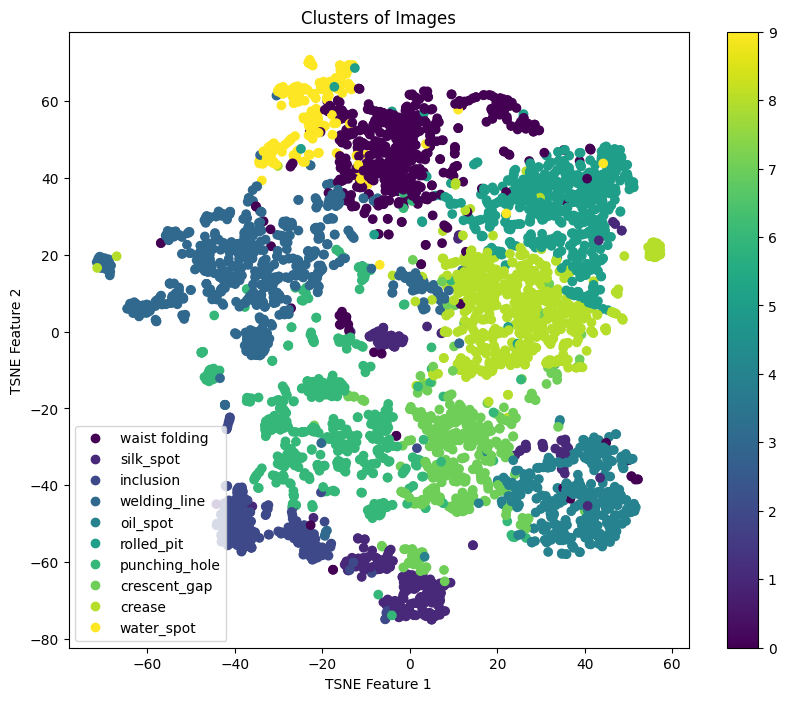

In [2]:
# Import necessary libraries
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change image brightness, contrast, etc.
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to load and preprocess images
def load_and_process_images(image_folder, transform, augment_transform):
    processed_images = []
    labels = []
    for label_idx, label_name in enumerate(os.listdir(image_folder)):
        label_folder = os.path.join(image_folder, label_name)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(label_folder, filename)
                    image = Image.open(image_path).convert('RGB')
                    processed_images.append(transform(image))
                    labels.append(label_idx)
                    # Apply augmentation and add augmented image
                    augmented_image = augment_transform(image)
                    processed_images.append(augmented_image)
                    labels.append(label_idx)
    return torch.stack(processed_images), labels

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the final fully connected layer
model = model.to(device)
model.eval()

# Function to extract features using ResNet-50
def extract_features(images, model, batch_size=32):
    model.eval()
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size].to(device)
            batch_features = model(batch_images).squeeze().cpu().numpy()
            features.append(batch_features)
    return np.vstack(features)

# Function for hierarchical clustering
def perform_hierarchical_clustering(features, num_clusters):
    clustering = AgglomerativeClustering(n_clusters=num_clusters)
    predicted_labels = clustering.fit_predict(features)
    return predicted_labels

# Specify image folder containing dataset
image_folder = '/content/drive/MyDrive/Colab Notebooks/Datasets/defects_kaggle'

# Load and preprocess images
processed_images, labels = load_and_process_images(image_folder, transform, augment_transform)
processed_images = processed_images.to(device)

# Extract features using ResNet-50
features = extract_features(processed_images, model)

# Perform hierarchical clustering on extracted features
num_clusters = len(os.listdir(image_folder))  # Number of clusters based on folder names
predicted_labels = perform_hierarchical_clustering(features, num_clusters)

# Reduce dimensionality for visualization
pca = PCA(n_components=50)
pca_features = pca.fit_transform(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Clusters of Images')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=os.listdir(image_folder))
plt.colorbar(scatter)
plt.show()


In [3]:
from sklearn.metrics import silhouette_score

# Compute the Silhouette Score
silhouette_avg = silhouette_score(features, predicted_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.0731


In [6]:
from collections import Counter
import numpy as np

def compute_purity(labels, predicted_labels):
    total = len(labels)
    cluster_labels = np.unique(predicted_labels)
    majority_sum = 0

    for cluster in cluster_labels:
        cluster_indices = np.where(predicted_labels == cluster)
        cluster_true_labels = labels[cluster_indices]
        most_common_label, count = Counter(cluster_true_labels).most_common(1)[0]
        majority_sum += count

    purity = majority_sum / total
    return purity

# Compute Cluster Purity
purity = compute_purity(np.array(labels), predicted_labels)
print(f"Cluster Purity: {purity:.4f}")

Cluster Purity: 0.4508


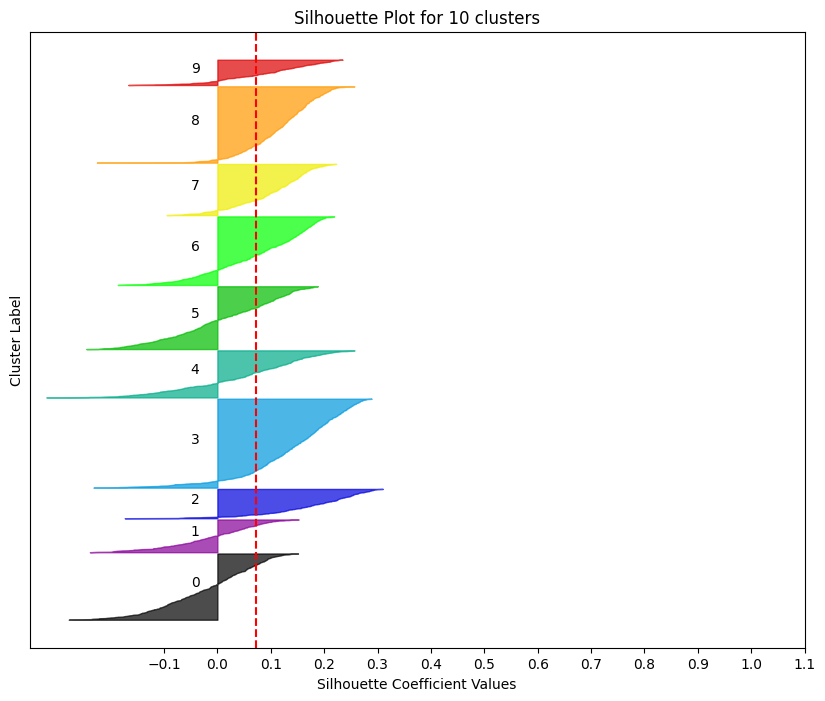

In [7]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

# Silhouette Plot
def plot_silhouette(features, predicted_labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    silhouette_avg = silhouette_score(features, predicted_labels)
    sample_silhouette_values = silhouette_samples(features, predicted_labels)

    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[predicted_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / num_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Plot for {num_clusters} clusters')
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.1))
    plt.show()

plot_silhouette(features, predicted_labels)